# Computer Vision - Final Project
##### Trevor Adelson + Ben Salter

In [6]:
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

KeyboardInterrupt: 

In [17]:
def plot(history_mlp):
    plt.plot(history_mlp.history['stable_height'], label='Train')
    plt.plot(history_mlp.history['val_stable_height'], label='Validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Training and validating accuracy')
    plt.legend()
    plt.show()
    
    plt.plot(history_mlp.history['loss'], label='Train')
    plt.plot(history_mlp.history['val_loss'], label='Validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Training and validating loss')
    plt.legend()
    plt.show()

In [6]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img / 255.0  # Normalize to [0,1]
    return img

# Create the model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1)  # Predict stable height as a continuous value
    ])
    return model

# Custom data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_folder, batch_size=32, target_size=(224, 224), shuffle=True):
        self.df = df
        self.img_folder = img_folder
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.df) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        X = np.array([preprocess_image(f"{self.img_folder}/{img_id}.jpg", self.target_size) 
                      for img_id in batch_df['id']])
        y = batch_df['stable_height'].values

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

class TestEvaluationCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_generator):
        super().__init__()
        self.test_generator = test_generator
        self.test_losses = []
        self.test_maes = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_mae = self.model.evaluate(self.test_generator, verbose=0)
        self.test_losses.append(test_loss)
        self.test_maes.append(test_mae)
        print(f"\nTest Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

# Function to plot learning curves
def plot_learning_curves(history, test_losses, test_maes):
    plt.figure(figsize=(12, 5))
    
    # Plot training & test loss values
    plt.subplot(121)
    plt.plot(history.history['loss'])
    plt.plot(test_losses)
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    
    # Plot training & test MAE values
    plt.subplot(122)
    plt.plot(history.history['mae'])
    plt.plot(test_maes)
    plt.title('Model MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    folder_prefix = "./COMP90086_2024_Project_"
    
    # Load data
    train_folder = folder_prefix + "train/"
    train_csv_path = train_folder + "train.csv"
    train_img_folder = train_folder + "train"
    df = pd.read_csv(train_csv_path)
    
    # Split the data into training and test sets
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Create data generators
    train_generator = DataGenerator(train_df, train_img_folder)
    test_generator = DataGenerator(test_df, train_img_folder, shuffle=False)
    
    # Create and compile the model
    model = create_model()
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Create the custom callback
    test_callback = TestEvaluationCallback(test_generator)
    
    # Train the model
    history = model.fit(train_generator, epochs=10, callbacks=[test_callback])
    
    # Plot learning curves
    plot_learning_curves(history, test_callback.test_losses, test_callback.test_maes)
    
    # Final evaluation
    final_test_loss, final_test_mae = model.evaluate(test_generator)
    print(f"\nFinal Test MAE: {final_test_mae:.4f}")
    
    # Example prediction
    test_predictions = model.predict(test_generator)
    print("\nSample predictions:")
    for true, pred in zip(test_df['stable_height'].values[:5], test_predictions[:5]):
        print(f"True: {true}, Predicted: {pred[0]:.2f}")

NameError: name 'tf' is not defined

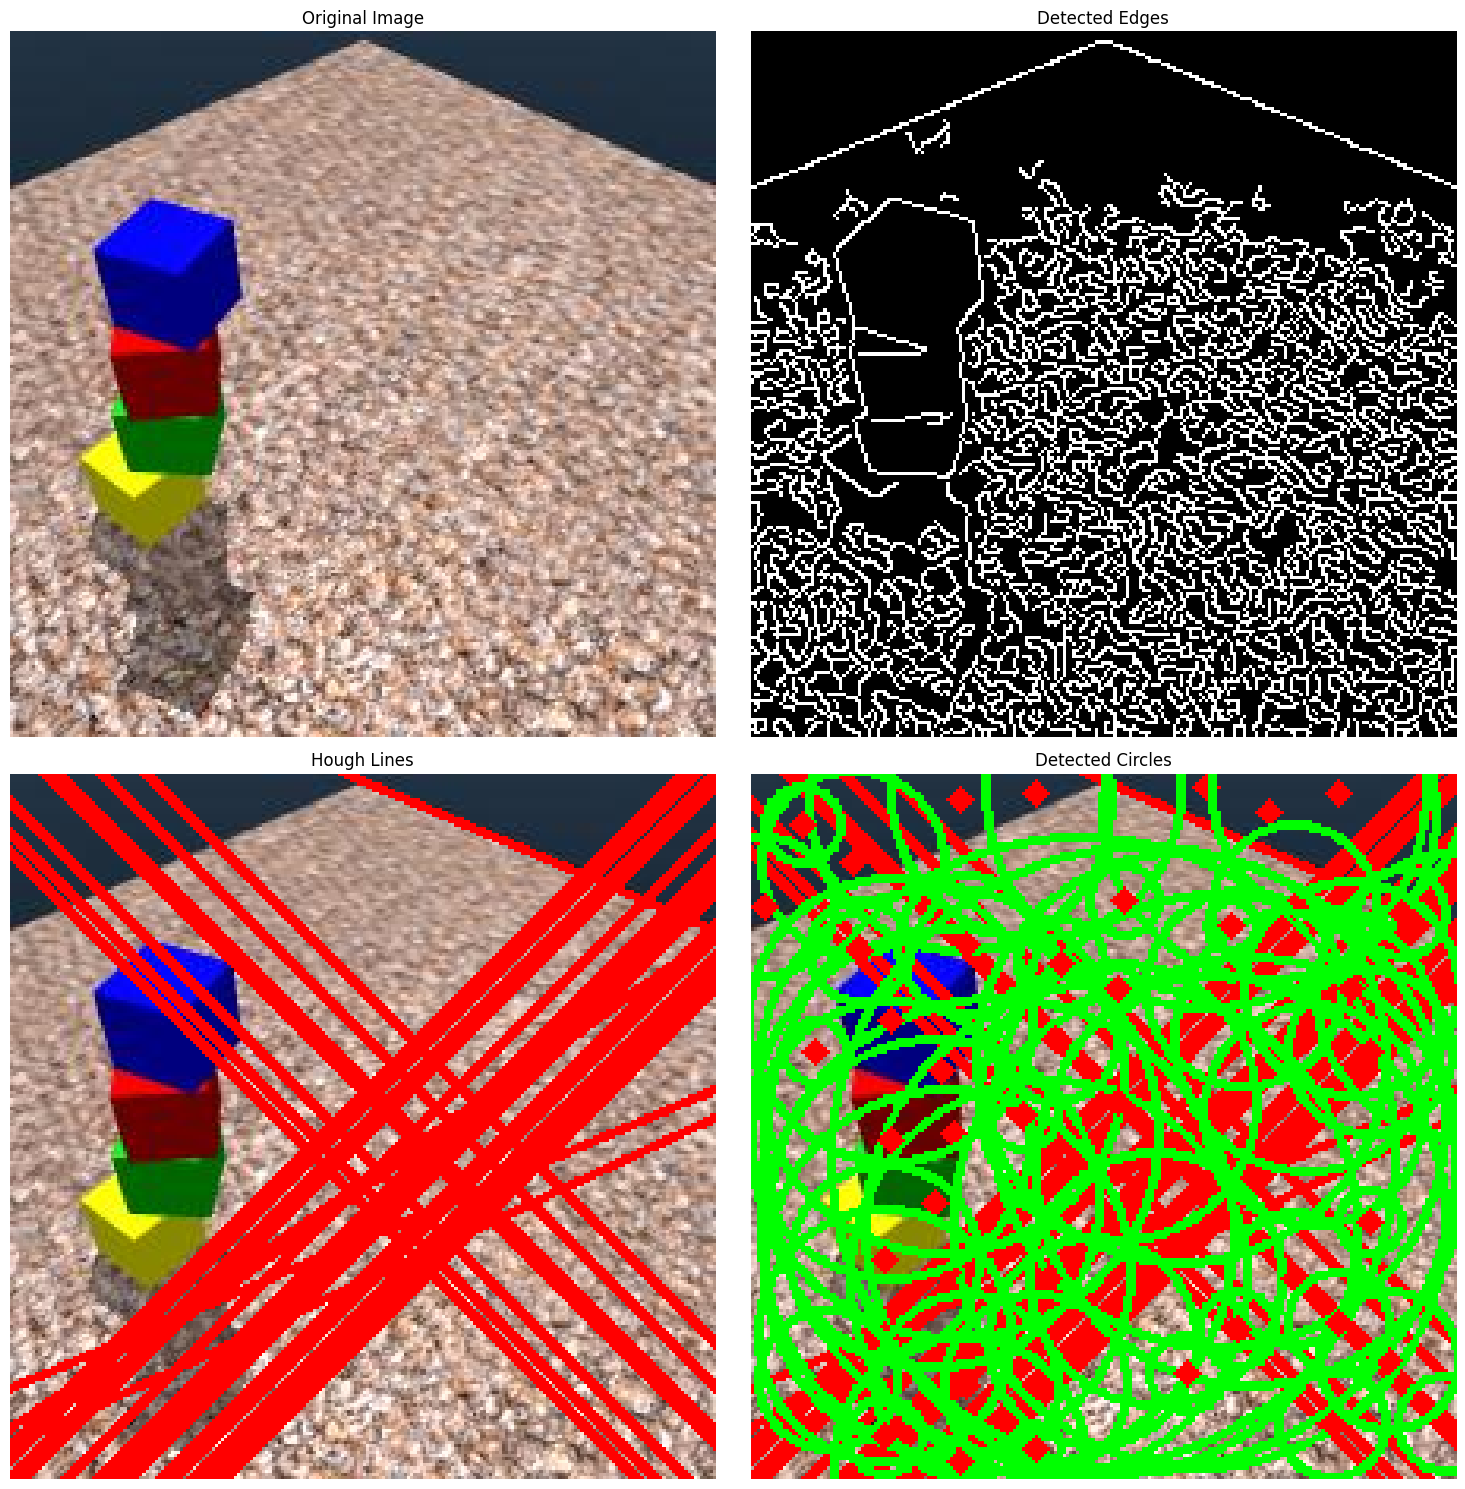

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    return cv2.imread(path)

def preprocess(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    return edges

def hough_transform(edges):
    return cv2.HoughLines(edges, 1, np.pi/180, threshold=100)

def draw_lines(image, lines):
    result = image.copy()
    if lines is not None:
        for rho, theta in lines[:, 0]:
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
            x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
            cv2.line(result, (x1, y1), (x2, y2), (0, 0, 255), 2)
    return result

def detect_circles(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20,
                               param1=50, param2=30, minRadius=0, maxRadius=0)
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            cv2.circle(image, (i[0], i[1]), i[2], (0, 255, 0), 2)
            cv2.circle(image, (i[0], i[1]), 2, (0, 0, 255), 3)
    return image

def display_results(original, edges, hough_lines, circles):
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    axs = axs.ravel()

    images = [original, edges, hough_lines, circles]
    titles = ['Original Image', 'Detected Edges', 'Hough Lines', 'Detected Circles']
    
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        axs[i].imshow(img)
        axs[i].set_title(title)
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

def display(image_path):
    img = load_image(image_path)
    edges = preprocess(img)
    lines = hough_transform(edges)
    hough_lines = draw_lines(img, lines)
    circles = detect_circles(hough_lines.copy())
    display_results(img, edges, hough_lines, circles)


display(train_img_folder + '/173.jpg')

In [68]:
def process_images(input_folder, output_folder):
    # Create output folder if it doesn't exist
    Path(output_folder).mkdir(parents=True, exist_ok=True)
    
    # Get all image files in the input folder
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    image_files = [f for f in os.listdir(input_folder) if os.path.splitext(f.lower())[1] in image_extensions]
    
    for image_file in image_files:
        # Read the image
        input_path = os.path.join(input_folder, image_file)
        image = cv2.imread(input_path)
        
        if image is None:
            print(f"Failed to read image: {input_path}")
            continue
        
        # Generate images
        outlines = isolate_blocks(image)
        
        # Save the outline image
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, outlines)
        
        print(f"Processed: {image_file}")

output_folder = "block_outlines_train"
process_images(train_folder + "/train", output_folder)

Processed: 625993.jpg
Processed: 980276.jpg
Processed: 14661.jpg
Processed: 930997.jpg
Processed: 600211.jpg
Processed: 20442.jpg
Processed: 597977.jpg
Processed: 274801.jpg
Processed: 758625.jpg
Processed: 904561.jpg
Processed: 706769.jpg
Processed: 219337.jpg
Processed: 489702.jpg
Processed: 636541.jpg
Processed: 170756.jpg
Processed: 845084.jpg
Processed: 879428.jpg
Processed: 437635.jpg
Processed: 669855.jpg
Processed: 671242.jpg
Processed: 335751.jpg
Processed: 911025.jpg
Processed: 689051.jpg
Processed: 976022.jpg
Processed: 383350.jpg
Processed: 527902.jpg
Processed: 864911.jpg
Processed: 943422.jpg
Processed: 588091.jpg
Processed: 182226.jpg
Processed: 223123.jpg
Processed: 1121.jpg
Processed: 170479.jpg
Processed: 6584.jpg
Processed: 668335.jpg
Processed: 646626.jpg
Processed: 622220.jpg
Processed: 794904.jpg
Processed: 77108.jpg
Processed: 813814.jpg
Processed: 542808.jpg
Processed: 452272.jpg
Processed: 160386.jpg
Processed: 79120.jpg
Processed: 172956.jpg
Processed: 558170.

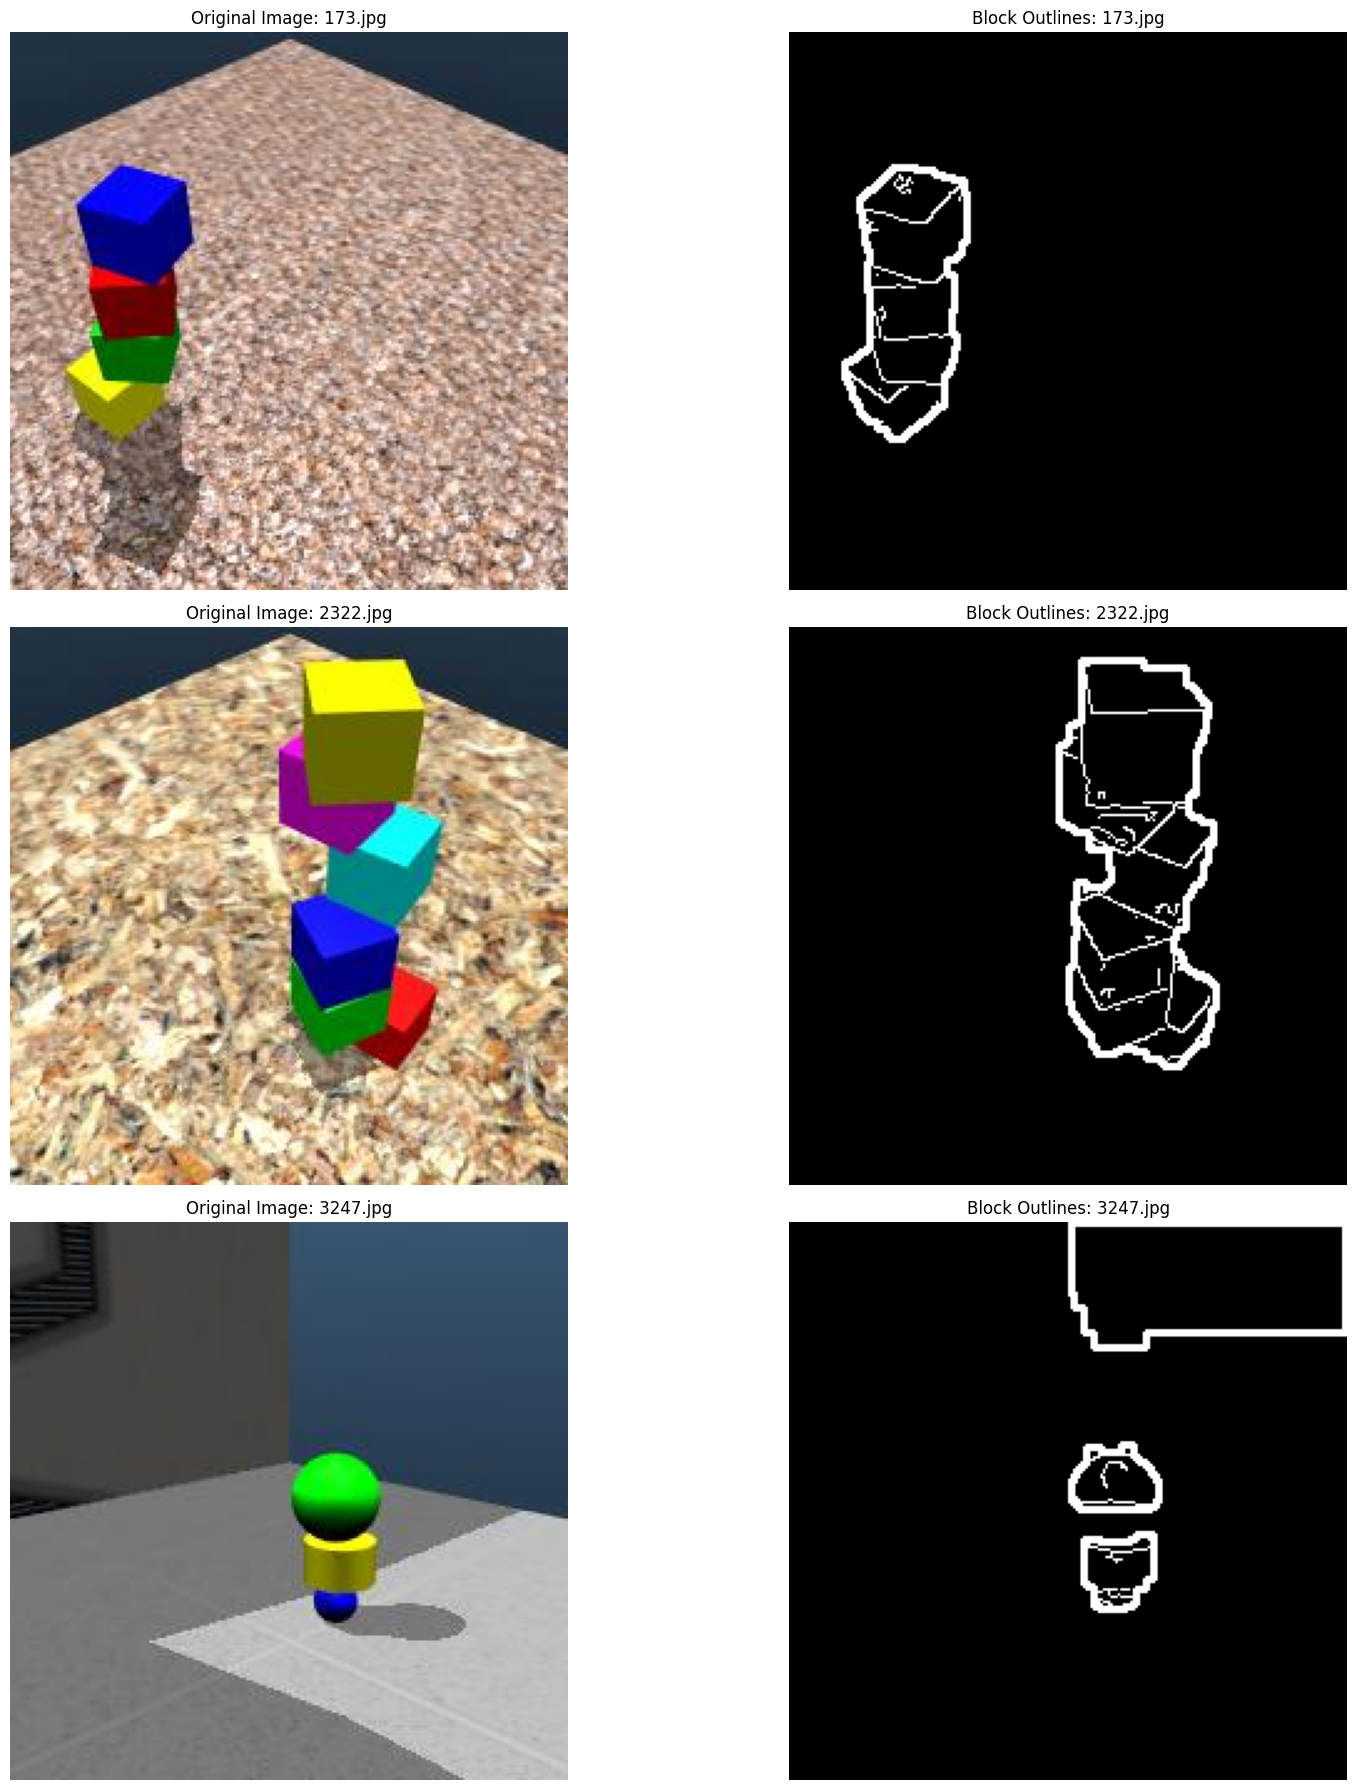

In [51]:
import cv2
import numpy as np
import os
from pathlib import Path

def detect_block_outlines(image):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define color ranges for common block colors
    color_ranges = [
        ((0, 100, 100), (10, 255, 255)),    # Red
        ((170, 100, 100), (180, 255, 255)), # Red (wraps around)
        ((20, 100, 100), (30, 255, 255)),   # Yellow
        ((45, 100, 100), (75, 255, 255)),   # Green
        ((90, 100, 100), (130, 255, 255)),  # Blue
        ((140, 100, 100), (170, 255, 255)), # Purple
    ]
    
    # Create a mask for the blocks
    mask = np.zeros(hsv.shape[:2], dtype=np.uint8)
    for lower, upper in color_ranges:
        color_mask = cv2.inRange(hsv, lower, upper)
        mask = cv2.bitwise_or(mask, color_mask)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area
    min_area = 100  # Adjust this value based on your image size and block size
    filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]
    
    # Create a blank image to draw the outlines
    outline_image = np.zeros(image.shape[:2], dtype=np.uint8)
    
    # Draw the filtered contours
    cv2.drawContours(outline_image, filtered_contours, -1, 255, 2)
    
    # Apply Canny edge detection only to the areas with blocks
    edges = cv2.Canny(image, 50, 150)
    block_edges = cv2.bitwise_and(edges, mask)
    
    # Combine the contour outlines with block edges
    combined_outlines = cv2.bitwise_or(outline_image, block_edges)
    
    return combined_outlines

def display_results(image_paths, train_img_folder):
    num_images = len(image_paths)
    fig, axs = plt.subplots(num_images, 2, figsize=(18, 6*num_images))
    
    if num_images == 1:
        axs = axs.reshape(1, -1)
    
    for i, path in enumerate(image_paths):
        full_path = train_folder + '/train/' + path
        
        # Original image
        original = cv2.imread(full_path)
        original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        axs[i, 0].imshow(original_rgb)
        axs[i, 0].set_title(f'Original Image: {path}')
        axs[i, 0].axis('off')
        
        # Block mask and outlines
        outlines = detect_block_outlines(original)
        axs[i, 1].imshow(outlines, cmap='gray')
        axs[i, 1].set_title(f'Block Outlines: {path}')
        axs[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()




# Example usage remains the same
image_paths = ['173.jpg', '2322.jpg', '3247.jpg']
display_results(image_paths, train_img_folder)

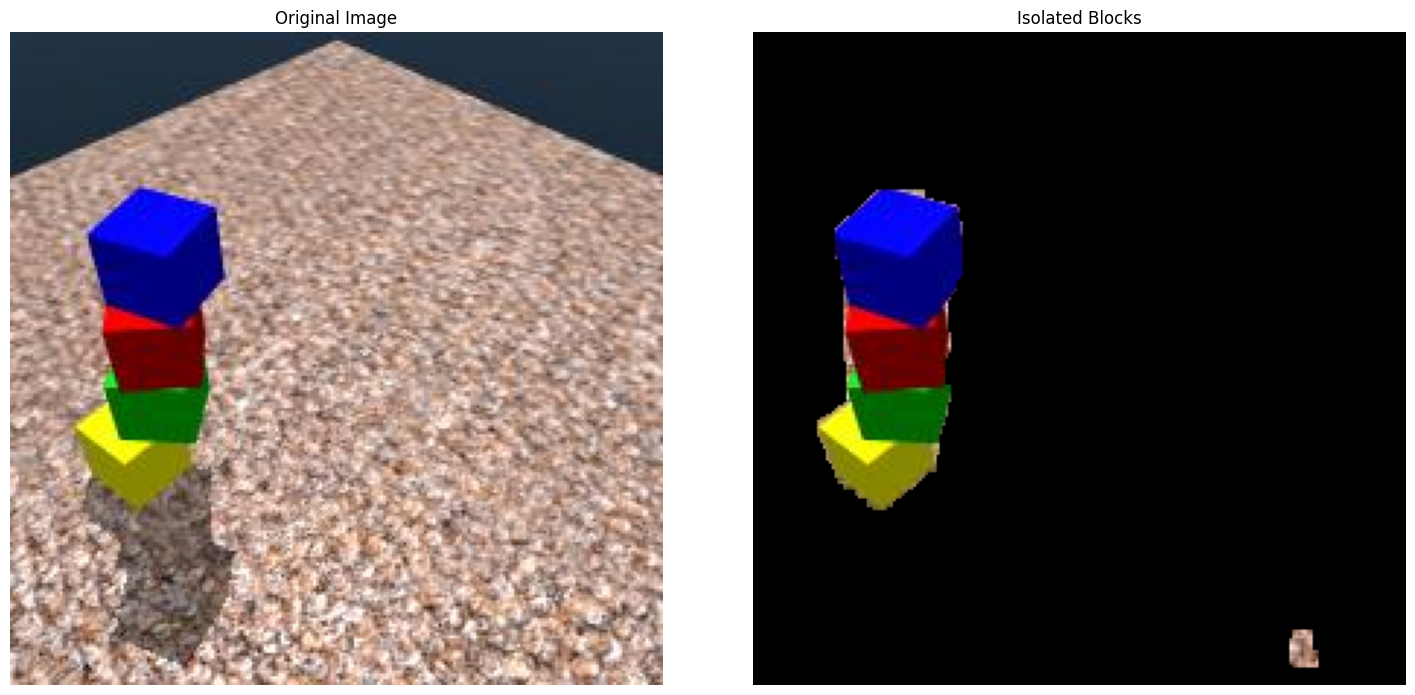

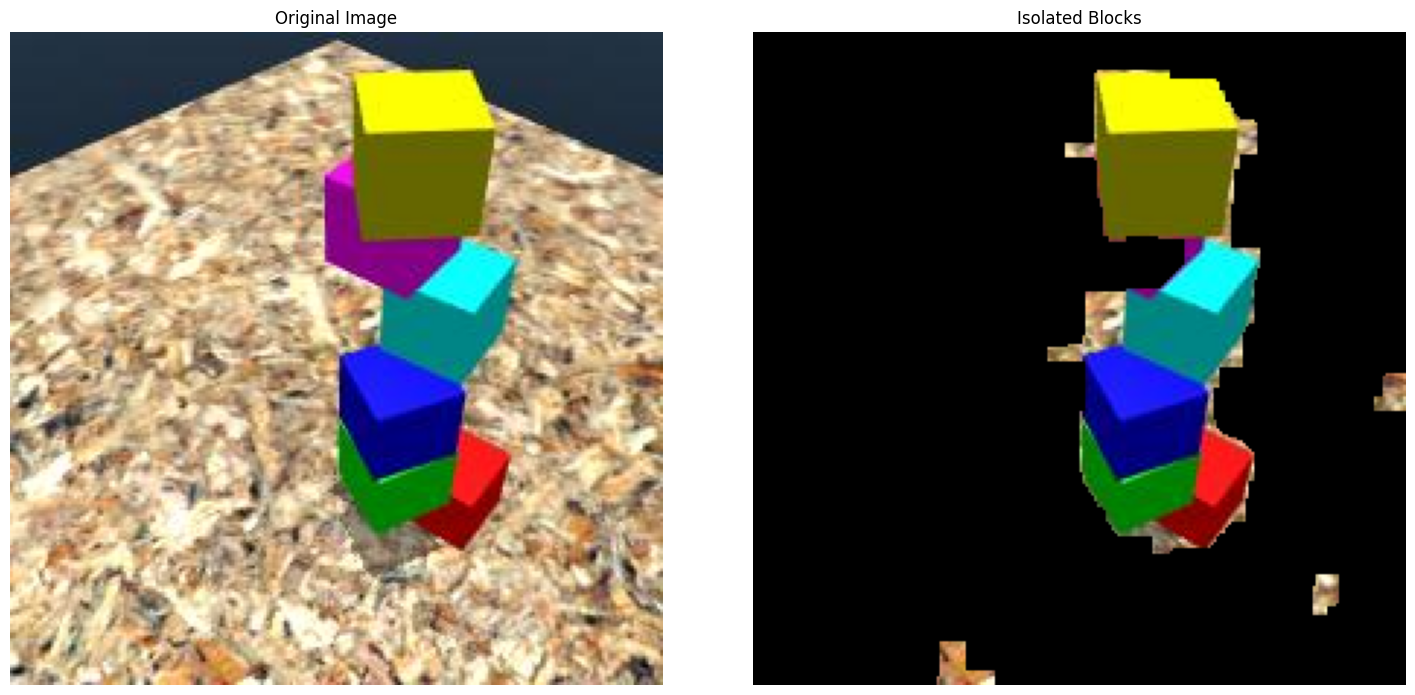

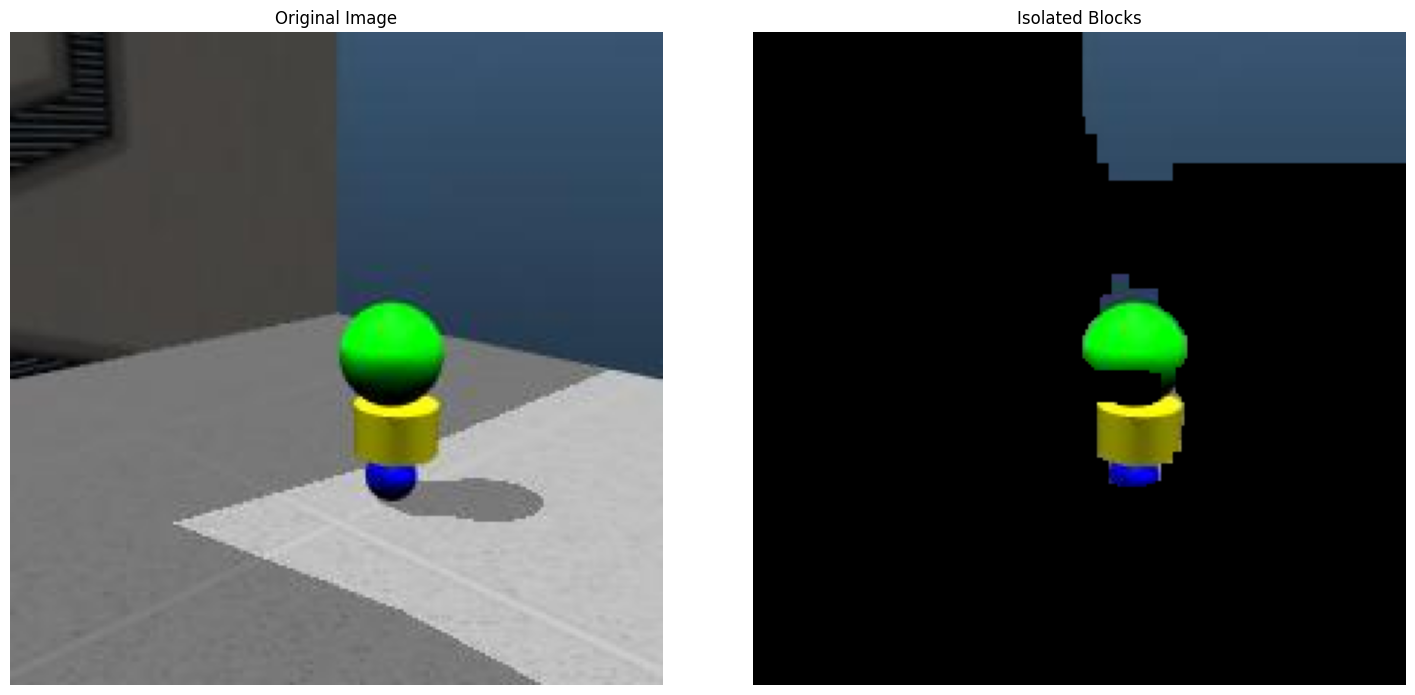

Processing complete. Check the output above.


In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def isolate_blocks(img):
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define color ranges for blocks (more aggressive)
    color_ranges = [
        ((0, 100, 100), (10, 255, 255)),    # Red
        ((20, 100, 100), (30, 255, 255)),   # Yellow
        ((35, 100, 100), (85, 255, 255)),   # Green
        ((90, 100, 100), (130, 255, 255)),  # Blue
    ]
    
    # Create a mask for the blocks based on color
    color_mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for lower, upper in color_ranges:
        mask = cv2.inRange(hsv, np.array(lower), np.array(upper))
        color_mask = cv2.bitwise_or(color_mask, mask)
    
    # Apply morphological operations to refine the mask
    kernel = np.ones((5,5), np.uint8)
    refined_mask = cv2.morphologyEx(color_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Perform connected component analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(refined_mask, connectivity=8)
    
    # Filter components based on area
    min_area = 100  # Adjust this value based on the size of your blocks
    block_mask = np.zeros_like(refined_mask)
    for i in range(1, num_labels):  # Start from 1 to skip the background
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            block_mask[labels == i] = 255
    
    # Create a new image with just the blocks
    result = cv2.bitwise_and(img, img, mask=block_mask)
    
    return result

# Process and display each image
for path in ['173.jpg', '2322.jpg', '3247.jpg']:
    # Read the image
    img = cv2.imread(train_folder + '/train/' + path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Process the image
    isolated_blocks = isolate_blocks(img)
    isolated_blocks_rgb = cv2.cvtColor(isolated_blocks, cv2.COLOR_BGR2RGB)
    
    # Display the original and processed images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    ax1.imshow(img_rgb)
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    ax2.imshow(isolated_blocks_rgb)
    ax2.set_title('Isolated Blocks')
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Processing complete. Check the output above.")

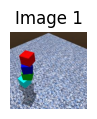

Image block colors (bottom to top): ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']


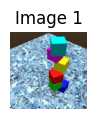

Image block colors (bottom to top): ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']


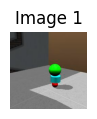

Image block colors (bottom to top): ['unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown', 'unknown']


In [75]:
import cv2
import numpy as np

def get_block_colors(image_path):
    # Read the image
    img = cv2.imread(image_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(f'Image {i}')
    plt.axis('off')
    plt.show()
    
    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define color ranges
    color_ranges = {
        'red': ([0, 100, 100], [10, 255, 255]),
        'yellow': ([20, 100, 100], [30, 255, 255]),
        'green': ([40, 100, 100], [80, 255, 255]),
        'blue': ([100, 100, 100], [140, 255, 255]),
        'purple': ([140, 100, 100], [170, 255, 255]),
        'cyan': ([80, 100, 100], [100, 255, 255])
    }
    
    # Find contours
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by y-coordinate (bottom to top)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1], reverse=True)
    
    block_colors = []
    
    for contour in contours:
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        
        # Extract region of interest
        roi = hsv[y:y+h, x:x+w]
        
        # Calculate average color
        avg_color = np.mean(roi, axis=(0, 1))
        
        # Determine color
        for color, (lower, upper) in color_ranges.items():
            if np.all(avg_color >= lower) and np.all(avg_color <= upper):
                block_colors.append(color)
                break
        else:
            block_colors.append('unknown')
    
    return block_colors
    
# Analyze each image
for path in ['173.jpg', '2322.jpg', '3247.jpg']:
    # Read the image
    image_path = train_folder + '/train/' + path
    colors = get_block_colors(image_path)
    print(f"Image block colors (bottom to top): {colors}")

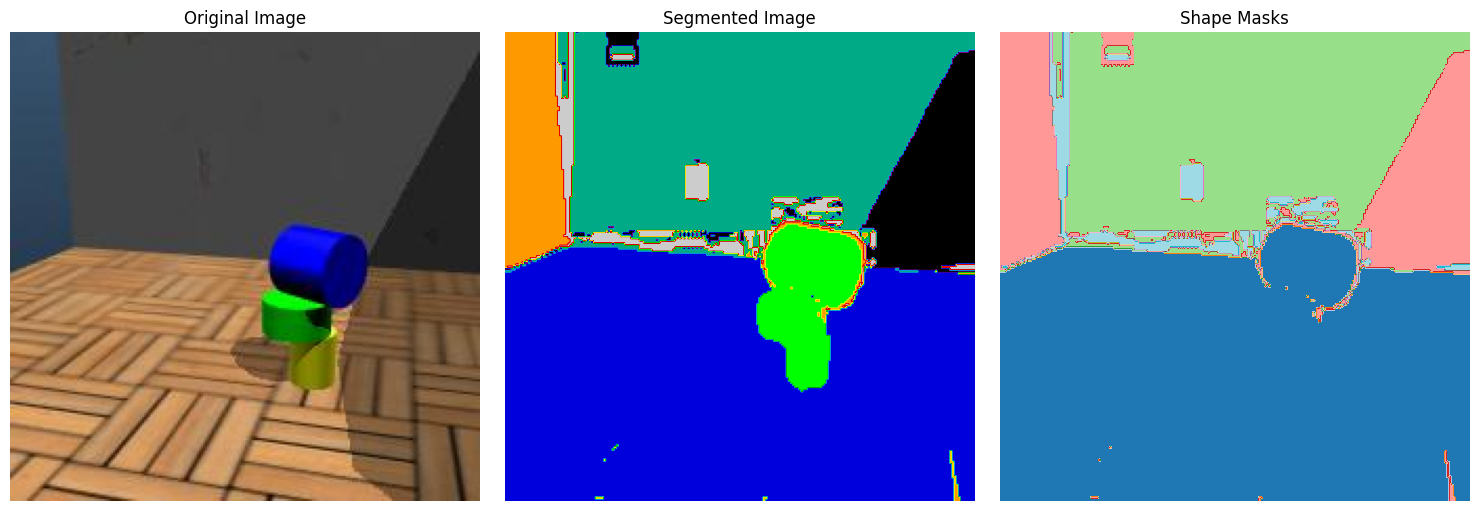

[('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cylinder'), ('red', 'cube'), ('red', 'cube'), ('red', 'cube'), ('red', 'cylinder'), ('red', 'cube'), ('cyan', 'cube'), ('re

OverflowError: Python integer 256 out of bounds for uint8

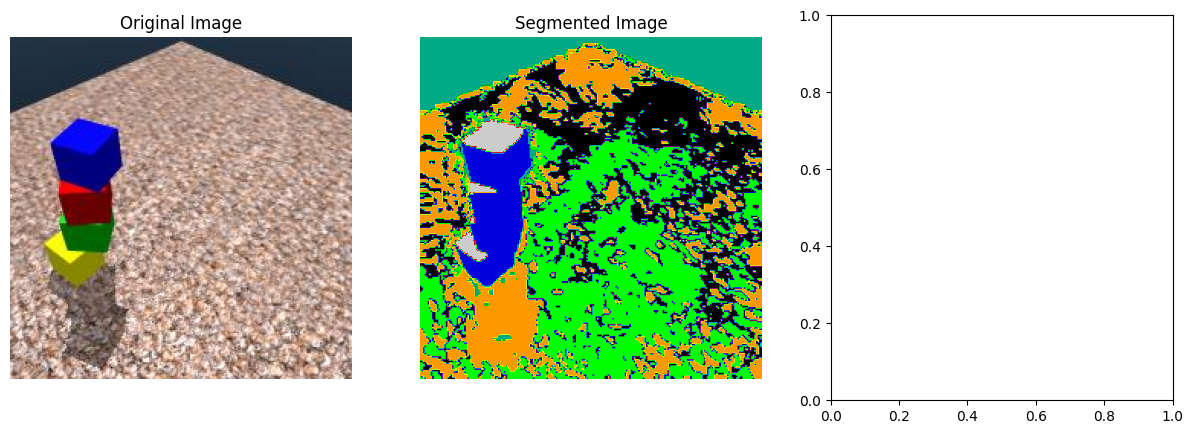

In [12]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def preprocess_image(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    denoised = cv2.fastNlMeansDenoisingColored(hsv, None, 10, 10, 7, 21)
    denoised[:,:,2] = cv2.equalizeHist(denoised[:,:,2])
    return denoised

def segment_colors(image, n_colors=6):
    pixels = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=n_colors, random_state=42)
    kmeans.fit(pixels)
    segmented = kmeans.labels_.reshape(image.shape[:2])
    return segmented

def detect_shapes(segmented):
    shapes = []
    shape_masks = []
    for label in np.unique(segmented):
        binary = (segmented == label).astype(np.uint8)
        contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            circularity = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0
            
            if circularity > 0.85:
                shape = 'sphere'
            elif 0.6 < circularity < 0.85:
                shape = 'cylinder'
            else:
                shape = 'cube'
            
            shapes.append((label, shape))
            shape_masks.append(binary)
    
    return shapes, shape_masks

def classify_colors(image, segmented):
    color_names = ['blue', 'cyan', 'green', 'yellow', 'red', 'magenta']
    color_values = [
        (255, 0, 0), (0, 255, 255), (0, 255, 0),
        (0, 255, 255), (0, 0, 255), (255, 0, 255)
    ]
    colors = []
    
    for label in np.unique(segmented):
        mask = (segmented == label).astype(np.uint8)
        mean_color = cv2.mean(image, mask=mask)[:3]
        distances = [np.linalg.norm(np.array(mean_color) - np.array(color)) for color in color_values]
        closest_color = color_names[np.argmin(distances)]
        colors.append((label, closest_color))
    
    return colors

def process_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    processed = preprocess_image(image)
    segmented = segment_colors(processed)
    shapes, shape_masks = detect_shapes(segmented)
    colors = classify_colors(processed, segmented)
    
    results = []
    for (label, shape), mask in zip(shapes, shape_masks):
        color = next(color for l, color in colors if l == label)
        results.append((color, shape))
    
    # Visualization
    plt.figure(figsize=(15, 5))
    plt.subplot(131)
    plt.imshow(image_rgb)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(132)
    plt.imshow(segmented, cmap='nipy_spectral')
    plt.title('Segmented Image')
    plt.axis('off')
    
    plt.subplot(133)
    combined_mask = np.zeros_like(segmented)
    for i, mask in enumerate(shape_masks):
        combined_mask += mask * (i + 1)
    plt.imshow(combined_mask, cmap='tab20')
    plt.title('Shape Masks')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return results

# Example usage
for image_name in ['54', '173', '245']:
    image_path = f'./COMP90086_2024_Project_train/train/{image_name}.jpg'
    results = process_image(image_path)
    print(results)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os
import numpy as np

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

class StabilityDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.stability_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        # Dynamically create height_to_class mapping
        unique_heights = sorted(self.stability_data.iloc[:, -1].unique())
        self.height_to_class = {height: idx for idx, height in enumerate(unique_heights)}
        self.num_classes = len(unique_heights)
        
        print(f"Unique heights found: {unique_heights}")
        print(f"Number of classes: {self.num_classes}")
        print(f"Height to class mapping: {self.height_to_class}")

    def __len__(self):
        return len(self.stability_data)

    def __getitem__(self, idx):
        img_name = str(self.stability_data.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, img_name + '.jpg')
        
        image = Image.open(img_path).convert('RGB')
        stability_height = self.stability_data.iloc[idx, -1]
        
        # Convert stability height to class index
        height_class = self.height_to_class[stability_height]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(height_class, dtype=torch.long)

class StabilityPredictor(nn.Module):
    def __init__(self, num_classes):
        super(StabilityPredictor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct / total
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%')
def main():
    # We only need to convert to tensor and normalize, as images are already 224x224
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_train/train.csv', img_dir='./COMP90086_2024_Project_train/train', transform=transform)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

    model = StabilityPredictor(num_classes=4)  # 4 classes for heights 3, 4, 5, 6
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, criterion, optimizer, num_epochs=10)

    torch.save(model.state_dict(), 'stability_predictor_new.pth')

if __name__ == '__main__':
    main()

Unique heights found: [1, 2, 3, 4, 5, 6]
Number of classes: 6
Height to class mapping: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os

class StabilityDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.stability_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.stability_data)

    def __getitem__(self, idx):
        # Convert the image filename to string
        img_name = str(self.stability_data.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        
        # Check if the file exists, if not, try adding .jpg extension
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, img_name + '.jpg')
        
        image = Image.open(img_path).convert('RGB')
        stability_height = self.stability_data.iloc[idx, -1]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(stability_height, dtype=torch.float32)

class StabilityPredictor(nn.Module):
    def __init__(self):
        super(StabilityPredictor, self).__init__()
        # Load pre-trained InceptionV3
        self.inception = models.inception_v3(pretrained=True)
        # Replace the final fully connected layer
        num_ftrs = self.inception.fc.in_features
        self.inception.fc = nn.Linear(num_ftrs, 1)

    def forward(self, x):
        # InceptionV3 returns tuple of (output, aux_output) when training
        if self.training:
            output, _ = self.inception(x)
        else:
            output = self.inception(x)
        return output

def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

def main():
    # Set up data transformations
    transform = transforms.Compose([
        transforms.Resize((299, 299)),  # InceptionV3 expects 299x299 images
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create dataset and dataloader
    dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_train/train.csv', img_dir='./COMP90086_2024_Project_train/train', transform=transform)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

    # Initialize the model, loss function, and optimizer
    model = StabilityPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=10)

    # Save the trained model
    torch.save(model.state_dict(), 'stability_predictor_inceptionv3.pth')

if __name__ == '__main__':
    main()

/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Loss: 1.8780
Epoch 2/10, Loss: 1.5841
Epoch 3/10, Loss: 1.4677
Epoch 4/10, Loss: 1.3972
Epoch 5/10, Loss: 1.3157
Epoch 6/10, Loss: 1.2513
Epoch 7/10, Loss: 1.2053
Epoch 8/10, Loss: 1.0837
Epoch 9/10, Loss: 1.0347
Epoch 10/10, Loss: 0.9072


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os

class StabilityDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.stability_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.stability_data)

    def __getitem__(self, idx):
        img_name = str(self.stability_data.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, img_name + '.jpg')
        image = Image.open(img_path).convert('RGB')
        stability_height = self.stability_data.iloc[idx, -1]
        stability_class = int(stability_height) - 1
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(stability_class, dtype=torch.long)

class StabilityPredictor(nn.Module):
    def __init__(self, num_classes=6):
        super(StabilityPredictor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create full dataset
    full_dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_train/train.csv', 
                                    img_dir='./COMP90086_2024_Project_train/train', 
                                    transform=transform)
    
    # Split dataset into train and validation
    dataset_size = len(full_dataset)
    val_size = int(0.1 * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    model = StabilityPredictor(num_classes=6)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30)

    torch.save(model.state_dict(), 'stability_predictor_resnet50_classification.pth')

if __name__ == '__main__':
    main()

/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
Train Loss: 1.6718, Train Acc: 24.25%
Val Loss: 1.7389, Val Acc: 24.74%
------------------------------------------------------------
Epoch 2/30
Train Loss: 1.5963, Train Acc: 25.07%
Val Loss: 1.6057, Val Acc: 25.39%
------------------------------------------------------------
Epoch 3/30
Train Loss: 1.5626, Train Acc: 27.18%
Val Loss: 1.5457, Val Acc: 29.69%
------------------------------------------------------------
Epoch 4/30
Train Loss: 1.5209, Train Acc: 31.00%
Val Loss: 1.4422, Val Acc: 36.98%
------------------------------------------------------------
Epoch 5/30
Train Loss: 1.4295, Train Acc: 39.13%
Val Loss: 1.4802, Val Acc: 39.19%
------------------------------------------------------------
Epoch 6/30
Train Loss: 1.3465, Train Acc: 44.31%
Val Loss: 1.3754, Val Acc: 43.36%
------------------------------------------------------------
Epoch 7/30
Train Loss: 1.2565, Train Acc: 47.63%
Val Loss: 1.3826, Val Acc: 42.32%
-----------------------------------------------------

KeyboardInterrupt: 

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import os

class StabilityDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.stability_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.stability_data)

    def __getitem__(self, idx):
        img_name = str(self.stability_data.iloc[idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, img_name + '.jpg')
        image = Image.open(img_path).convert('RGB')
        stability_height = self.stability_data.iloc[idx, -1]
        stability_class = int(stability_height) - 1
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(stability_class, dtype=torch.long)

class StabilityPredictor(nn.Module):
    def __init__(self, num_classes=6):
        super(StabilityPredictor, self).__init__()
        self.efficientnet = models.efficientnet_v2_s(pretrained=True)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

def main():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create full dataset
    full_dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_train/train.csv', 
                                    img_dir='./COMP90086_2024_Project_train/train', 
                                    transform=transform)
    
    # Split dataset into train and validation
    dataset_size = len(full_dataset)
    val_size = 0 #int(0.1 * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    model = StabilityPredictor(num_classes=6)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

    torch.save(model.state_dict(), 'stability_predictor_efficientnetv2_classification.pth')

if __name__ == '__main__':
    main()

/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/Documents/COMP90086_Project/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/8
Train Loss: 1.5040, Train Acc: 34.23%
Val Loss: 1.4951, Val Acc: 40.36%
------------------------------------------------------------
Epoch 2/8
Train Loss: 1.2862, Train Acc: 46.44%
Val Loss: 1.2523, Val Acc: 48.05%
------------------------------------------------------------
Epoch 3/8
Train Loss: 1.1550, Train Acc: 53.27%
Val Loss: 1.1829, Val Acc: 51.82%
------------------------------------------------------------
Epoch 4/8
Train Loss: 1.0460, Train Acc: 58.71%
Val Loss: 1.1248, Val Acc: 56.77%
------------------------------------------------------------
Epoch 5/8
Train Loss: 0.9561, Train Acc: 62.88%
Val Loss: 1.1358, Val Acc: 56.25%
------------------------------------------------------------
Epoch 6/8
Train Loss: 0.8789, Train Acc: 66.65%
Val Loss: 1.1218, Val Acc: 57.94%
------------------------------------------------------------
Epoch 7/8
Train Loss: 0.7809, Train Acc: 70.76%
Val Loss: 1.1423, Val Acc: 59.51%
------------------------------------------------------------

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torchvision.models import EfficientNet_V2_S_Weights
from PIL import Image
import pandas as pd
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

class StabilityDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, augment=False):
        self.stability_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.stability_data) * (2 if self.augment else 1)

    def __getitem__(self, idx):
        original_idx = idx // 2 if self.augment else idx
        flip = self.augment and idx % 2 == 1

        img_name = str(self.stability_data.iloc[original_idx, 0])
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, img_name + '.jpg')
        image = Image.open(img_path).convert('RGB')
        
        stability_height = self.stability_data.iloc[original_idx, -1]
        stability_class = int(stability_height) - 1

        if flip:
            image = image.transpose(Image.Transpose.FLIP_LEFT_RIGHT)

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(stability_class, dtype=torch.long)

class StabilityPredictor(nn.Module):
    def __init__(self, num_classes=6):
        super(StabilityPredictor, self).__init__()
        weights = EfficientNet_V2_S_Weights.DEFAULT
        self.efficientnet = models.efficientnet_v2_s(weights=weights)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)

def calculate_dataset_stats(dataset):
    loader = DataLoader(dataset, batch_size=1, num_workers=0, shuffle=False)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in loader:
        for i in range(3):
            mean[i] += images[:, i, :, :].mean()
            std[i] += images[:, i, :, :].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, patience):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = 100. * correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = 100. * val_correct / val_total

        # Learning rate scheduler step
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 60)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model = model.state_dict()
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            model.load_state_dict(best_model)
            break

    return model

def main():
    # Create initial dataset without normalization
    initial_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    full_dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_train/train.csv', 
                                    img_dir='./COMP90086_2024_Project_train/train', 
                                    transform=initial_transform,
                                    augment=False)  # Disable augmentation for stat calculation

    # Calculate dataset statistics
    mean, std = calculate_dataset_stats(full_dataset)
    print(f"Dataset mean: {mean}")
    print(f"Dataset std: {std}")

    # Create final transform with calculated normalization
    final_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
    ])

    # Create full dataset with augmentation and correct normalization
    full_dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_train/train.csv', 
                                    img_dir='./COMP90086_2024_Project_train/train', 
                                    transform=final_transform,
                                    augment=True)  # Enable augmentation
    
    # Split dataset into train and validation
    dataset_size = len(full_dataset)
    val_size = int(0.1 * dataset_size)
    train_size = dataset_size - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

    model = StabilityPredictor(num_classes=6)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, patience=3)

    torch.save(model.state_dict(), 'stability_predictor_efficientnetv2_classification_augmented.pth')

if __name__ == '__main__':
    main()

Dataset mean: tensor([0.4677, 0.4412, 0.4065])
Dataset std: tensor([0.2721, 0.2285, 0.1913])
Epoch 1/30
Train Loss: 1.3743, Train Acc: 41.34%
Val Loss: 1.1764, Val Acc: 51.69%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 2/30
Train Loss: 1.1127, Train Acc: 54.75%
Val Loss: 1.0310, Val Acc: 58.01%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 3/30
Train Loss: 0.9882, Train Acc: 61.40%
Val Loss: 0.9815, Val Acc: 59.96%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 4/30
Train Loss: 0.8834, Train Acc: 65.99%
Val Loss: 0.9253, Val Acc: 63.35%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 5/30
Train Loss: 0.8155, Train Acc: 68.78%
Val Loss: 0.9119, Val Acc: 65.69%
Learning Rate: 0.001000
------------------------------------------------------------
Epoch 6/30
Train Loss: 0.7464, Train Acc: 71.61%
Val Loss: 0.8500, 

In [ ]:
import csv

def predict(model, test_loader, device):
    model.eval()
    predictions = []
    image_ids = []

    with torch.no_grad():
        for inputs, ids in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy() + 1)  # Add 1 to convert back to 1-6 range
            image_ids.extend(ids.numpy())  # Convert tensor to numpy array

    return predictions, image_ids

def main():
    # Set up device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Define transformation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load the unlabeled dataset
    test_dataset = StabilityDataset(csv_file='./COMP90086_2024_Project_test/test.csv', 
                                    img_dir='./COMP90086_2024_Project_test/test', 
                                    transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load the trained model
    model = StabilityPredictor(num_classes=6)
    model.load_state_dict(torch.load('stability_predictor_efficientnetv2_classification_augmented.pth'))
    model.to(device)

    # Make predictions
    predictions, image_ids = predict(model, test_loader, device)

    # Save predictions to CSV
    with open('predictions.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['id', 'labels'])
        for img_id, pred in zip(image_ids, predictions):
            writer.writerow([int(img_id) + 1, int(pred)])  # Ensure both are integers

    print("Predictions saved to predictions.csv")

if __name__ == '__main__':
    main()

Class distribution:
Class 1: 1920 samples (25.00%)
Class 2: 1920 samples (25.00%)
Class 3: 1536 samples (20.00%)
Class 4: 1152 samples (15.00%)
Class 5: 768 samples (10.00%)
Class 6: 384 samples (5.00%)

Imbalance ratio: 5.00


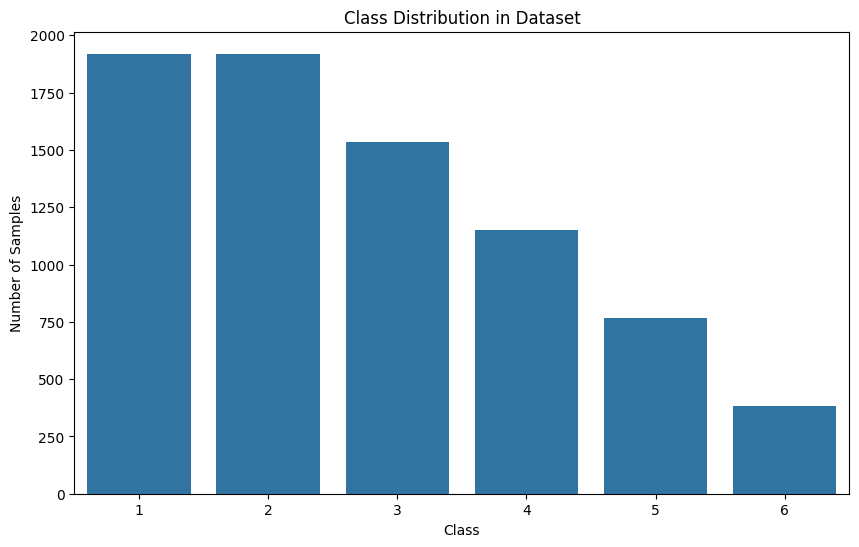

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def check_dataset_balance(csv_file, label_column):
    # Read the CSV file
    df = pd.read_csv(csv_file)
    
    # Count the occurrences of each class
    class_counts = df[label_column].value_counts().sort_index()
    
    # Calculate the percentage of each class
    class_percentages = 100 * class_counts / len(df)
    
    # Print the counts and percentages
    print("Class distribution:")
    for class_label, count in class_counts.items():
        percentage = class_percentages[class_label]
        print(f"Class {class_label}: {count} samples ({percentage:.2f}%)")
    
    # Calculate the imbalance ratio
    imbalance_ratio = class_counts.max() / class_counts.min()
    print(f"\nImbalance ratio: {imbalance_ratio:.2f}")
    
    # Visualize the class distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title('Class Distribution in Dataset')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.show()

# Usage example
check_dataset_balance('./COMP90086_2024_Project_train/train.csv', 'stable_height')